In [1]:
import torch
import torch.nn as nn
import prody as pr
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import MessagePassing, global_mean_pool
from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# Load the data
data = {}
with open("<path_to_labels>", "r") as file:
    for line in file:
        line = line.strip().split()
        key = line[0]
        value = float(line[1])
        data[key] = value

# Split the data into train and test sets
train_data, test_data = train_test_split(list(data.items()), test_size=0.2, random_state=42)

In [3]:
def load_protein_structure(file_path):
    return pr.parsePDB(file_path)


In [4]:
def create_data_loader(data):
    data_list = []
    for key, value in data:
        data_path = fr"<path_to_protein_structure>.pdb"
        protein_structure = load_protein_structure(data_path)
        protein_structure = protein_structure.select('name CA')
        positions = protein_structure.getCoords()

        # Compute distance matrix
        distances = cdist(positions, positions)

        # Create adjacency matrix based on distance threshold
        threshold = 20.0
        adjacency = distances < threshold

        np.fill_diagonal(adjacency, 0) #removing self loops

        # Convert data to PyTorch tensors
        positions_tensor = torch.tensor(positions, dtype=torch.float)
        adjacency_tensor = torch.tensor(adjacency, dtype=torch.float)
        labels_tensor = torch.tensor([value], dtype=torch.float)  # Assuming you have labels for the dataset

        # Convert adjacency matrix to edge indices
        edge_indices = torch.where(adjacency_tensor)
        edge_indices_tensor = torch.stack(edge_indices).long()

        # Create a PyTorch Geometric Data object
        data = Data(x=positions_tensor, edge_index=edge_indices_tensor, y=labels_tensor)
        data_list.append(data)
        
        # Create a DataLoader for batching the data during training
    loader = DataLoader(data_list, batch_size=1)
    return loader

In [5]:
train_data_loader = create_data_loader(train_data)
test_data_loader = create_data_loader(test_data)

@> 2036 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 9752 atoms and 1 coordinate set(s) were parsed in 0.10s.
@> 2976 atoms and 1 coordinate set(s) were parsed in 0.08s.
@> 5384 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 3108 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1337 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 9606 atoms and 1 coordinate set(s) were parsed in 0.09s.
@> 12144 atoms and 1 coordinate set(s) were parsed in 0.13s.
@> 1101 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 2018 atoms and 1 coordinate set(s) were parsed in 0.02s.
@> 4525 atoms and 1 coordinate set(s) were parsed in 0.05s.
@> 1337 atoms and 1 coordinate set(s) were parsed in 0.01s.
@> 4396 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 15912 atoms and 1 coordinate set(s) were parsed in 0.15s.
@> 3224 atoms and 1 coordinate set(s) were parsed in 0.04s.
@> 2248 atoms and 1 coordinate set(s) were parsed in 0.03s.
@> 1348 atoms and 1 coordinate set(s) 

In [6]:
# Define the SchNet convolutional layer

class SchNetConv(MessagePassing):
    def __init__(self, input_dim, hidden_dim):
        super(SchNetConv, self).__init__(aggr='add')
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x, edge_index):
        x = self.mlp(x)
        return self.propagate(edge_index, x=x)

    def message(self, x_j):
        return x_j

    def update(self, aggr_out, x):
        return aggr_out + x

# Define the SchNet model
class SchNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SchNet, self).__init__()
        self.conv1 = SchNetConv(input_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, edge_index, batch):
        edge_index = edge_index.to(torch.int64)
        x = self.conv1(x, edge_index)
        x = self.fc1(x)
        x = global_mean_pool(x, batch)
        x = self.fc2(x)
        x = torch.squeeze(x, dim=0)
        return x

# Create an instance of the SchNet model
model = SchNet(input_dim=3, hidden_dim=64, output_dim=1)


Epoch 1, Loss: 293625.3371
Epoch 2, Loss: 199105.6455
Epoch 3, Loss: 14283.8820
Epoch 4, Loss: 7156.3259
Epoch 5, Loss: 7232.9183
------------------------Done Training----------------------


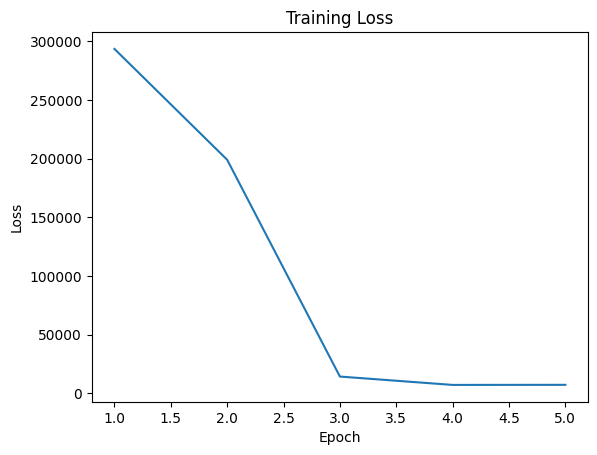

In [7]:
# Define the number of epochs
num_epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Set the model in training mode
model.train()

# Initialize an empty list to store the loss values
losses = []

# Training loop
for epoch in range(num_epochs):
    total_loss = 0

    # Iterate over the training data
    for data in train_data_loader:
        # Extract the input features and target labels
        inputs, edge_index, target = data.x, data.edge_index, data.y

        # Clear the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, edge_index, batch=data.batch)

        # Calculate the loss
        loss = criterion(outputs, target)

        # Backward pass
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Accumulate the total loss
        total_loss += loss.item()

    # Compute the average loss for the epoch
    average_loss = total_loss / len(train_data_loader)
    losses.append(average_loss)

    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {average_loss:.4f}")
print('------------------------Done Training----------------------')

# Plot the loss values
plt.plot(range(1, num_epochs + 1), losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [8]:
# Inference
model.eval()
predictions = []
labels = []
with torch.no_grad():
    for test_batch in test_data_loader:
        data = test_batch.to(device)
        output = model(data.x, data.edge_index, batch=test_batch.batch)
        predictions.append(output.cpu().numpy())
        labels.append(data.y.cpu().numpy())

In [9]:
predictions

[array([31.988775], dtype=float32),
 array([17.888533], dtype=float32),
 array([73.23052], dtype=float32),
 array([16.244852], dtype=float32),
 array([25.457417], dtype=float32),
 array([34.88753], dtype=float32),
 array([59.255177], dtype=float32),
 array([27.880842], dtype=float32),
 array([20.23753], dtype=float32)]

In [10]:
labels

[array([79.286], dtype=float32),
 array([31.881], dtype=float32),
 array([41.357], dtype=float32),
 array([33.786], dtype=float32),
 array([75.857], dtype=float32),
 array([49.214], dtype=float32),
 array([73.524], dtype=float32),
 array([73.595], dtype=float32),
 array([52.976], dtype=float32)]

In [11]:
# Calculate evaluation metrics
mse = mean_squared_error(labels, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(labels, predictions)
r2 = r2_score(labels, predictions)

# Print the metrics
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared (R2):", r2)


Mean Squared Error (MSE): 1096.3319
Root Mean Squared Error (RMSE): 33.110905
Mean Absolute Error (MAE): 29.794655
R-squared (R2): -2.4120537788681387
